In [1]:
import torch
import numpy as np
import warnings
from Bio.PDB import PDBIO, Chain, Residue, Polypeptide, Atom, PDBParser, Selection
from Bio.PDB.PDBExceptions import PDBConstructionWarning
from protein_residues import normal as RESIDUES
from Bio.SeqUtils import seq1, seq3
warnings.simplefilter('error')
list_path = "./data/pdb_list"
pdb_path ="./data/dompdb/"
parser = PDBParser(QUIET=True)

In [2]:
def PROCESS_RESIDUES(d):
    #X is unknown AA I should check this function to incorporate X
    #Additional AA, B - Asparagine, U - selenocysteine, Z - glutamic
    #acid, and O - ornithine (Doesn't clash with IUPAC convention)
    d['HIS'] = d['HIP']
    d = {key: val for key, val in d.items() if seq1(key) != 'X'}
    for key in d:
        atoms = d[key]['atoms']
        d[key] = {'CA': 'C'} | {key: val['symbol'] for key, val in atoms.items() if val['symbol'] != 'H' and key != 'CA'}
    return d
RESIDUES = PROCESS_RESIDUES(RESIDUES)

In [3]:
global_vars = np.zeros(3)[None,:]
filtered_pdb_ids =[]
seq_length = []
multi_chain = []
with open(list_path) as file:
    lines = [line.rstrip() for line in file]

In [4]:
for i in lines:
    model = parser.get_structure('',pdb_path+i)[0]
    chain = model.child_list[0]
    chain_seq = ''
    try:
        chain_bb =np.zeros((1,3))
        for res in chain:
            if (res.id[0] != ' ') or ('CA' not in res.child_dict) or (res.resname not in RESIDUES): continue
            chain_seq+=res.resname
        #Might change the Cb portion of Gly
            if res.resname=="GLY":
                bb = np.stack((res["N"].coord,res["CA"].coord,res["C"].coord),axis=0)
                chain_bb = np.concatenate((chain_bb, bb), axis = 0)
                # global_vars = np.concatenate((global_vars, bb),axis=0)
            else:
                bb = np.stack((res["N"].coord,res["CA"].coord,res["C"].coord,res["CB"].coord),axis=0)
                chain_bb = np.concatenate((chain_bb, bb), axis = 0)
        chain_bb = chain_bb[1:]
        CoM = np.mean(chain_bb,axis=0)
        chain_bb = chain_bb-CoM
        global_vars = np.concatenate((global_vars, chain_bb),axis=0)
        if len(chain_seq)>0:
            seq_length.append(len(seq1(chain_seq)))
            filtered_pdb_ids.append(i)
        if len(model.child_list)>1:
            multi_chain.append(True)
        else:
            multi_chain.append(False)
    except:
        pass

In [8]:
clean = global_vars[1:]

In [ ]:
#Output is
# global_vars = [] -> To calculate global variance
# filtered_pdb_ids =[] -> All PDBs where C, Ca, Cb, N exists
# seq_length = [] -> The sequence length of each pdb
# multi_chain = [] -> Boolean which indicates if the PDB contains multiple chains

# Data Visualization

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

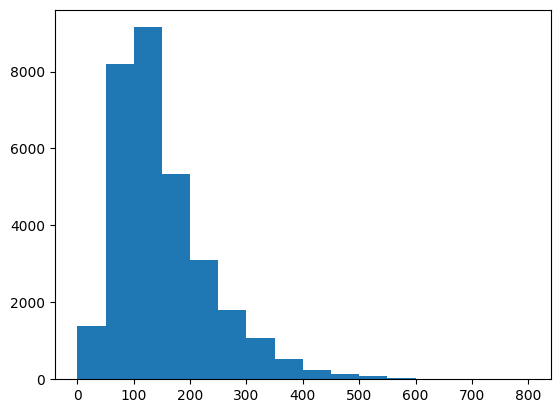

In [17]:
plt.hist(seq_length,bins=16,range=(0,800))
plt.show()

In [24]:
data=pd.DataFrame({'pdb_id':filtered_pdb_ids,'seq_length':seq_length,'is_multi_chain':multi_chain})

In [36]:
print(np.mean(global_vars,axis=0))#Sanity check, mean should be lim -> 0 if centered correctly
global_std = np.sqrt(np.var(global_vars.flatten()))
print(global_std)
std_3d=np.sqrt(np.var(global_vars,axis=0))
print(std_3d)

[2.57252928e-17 1.43223301e-15 6.67425759e-16]
9.975088793405108
[ 9.87331813  9.89513036 10.15436722]


In [38]:
with open('clean_pdb_id.txt', 'w') as f:
    for line in filtered_pdb_ids:
        f.write(f"{line}\n")

# Testing Stuff